In [1]:
import torch 
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt 
from tqdm import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.0


In [2]:
from pathlib import Path
from helper_functions import walk_through_dir

data_path=Path("data/")
image_path = data_path / "militaryvsother"
walk_through_dir(image_path)

There are 3 directories and 0 images in 'data\militaryvsother'.
There are 2 directories and 0 images in 'data\militaryvsother\test'.
There are 0 directories and 1281 images in 'data\militaryvsother\test\millitary'.
There are 0 directories and 1511 images in 'data\militaryvsother\test\other'.
There are 2 directories and 0 images in 'data\militaryvsother\train'.
There are 0 directories and 5125 images in 'data\militaryvsother\train\millitary'.
There are 0 directories and 6045 images in 'data\militaryvsother\train\other'.
There are 2 directories and 0 images in 'data\militaryvsother\validation'.
There are 0 directories and 1602 images in 'data\militaryvsother\validation\millitary'.
There are 0 directories and 1889 images in 'data\militaryvsother\validation\other'.


In [3]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/militaryvsother/train'),
 WindowsPath('data/militaryvsother/test'))

Random image path: data\militaryvsother\train\millitary\millitary_0_4231.jpeg
Image class: millitary
Image height: 256
Image width: 256


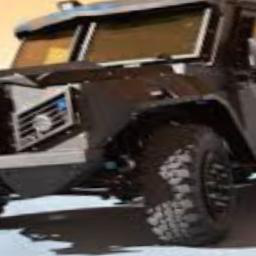

In [4]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpeg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

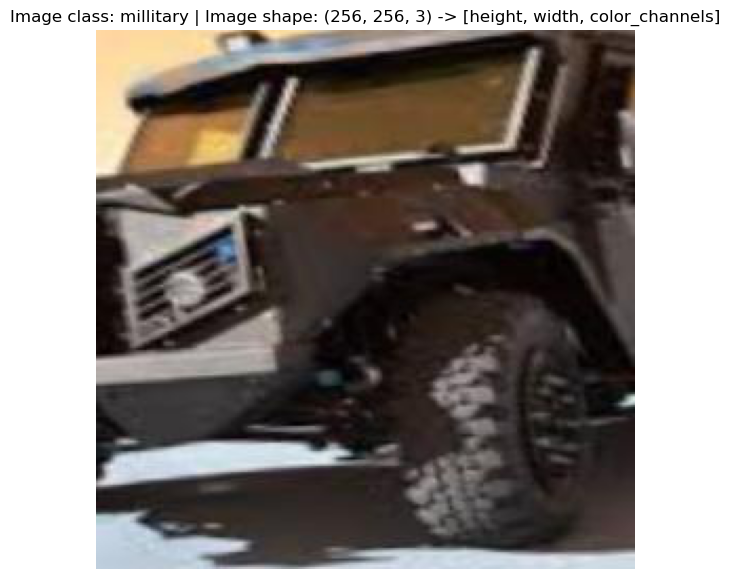

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transformer=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

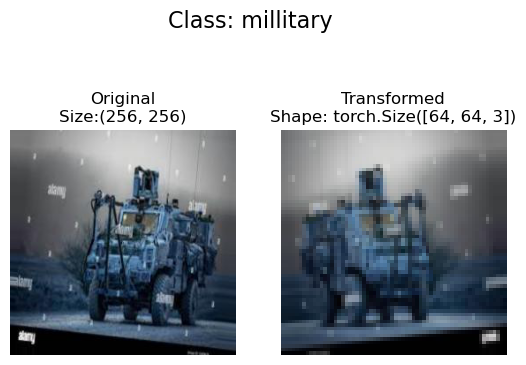

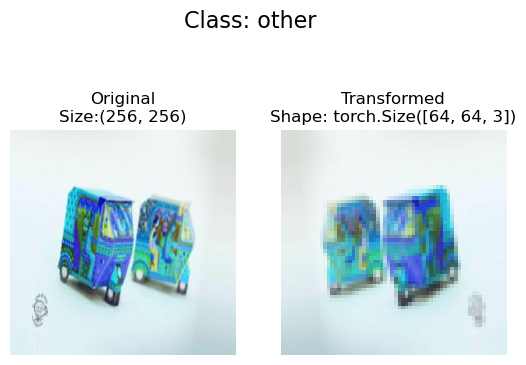

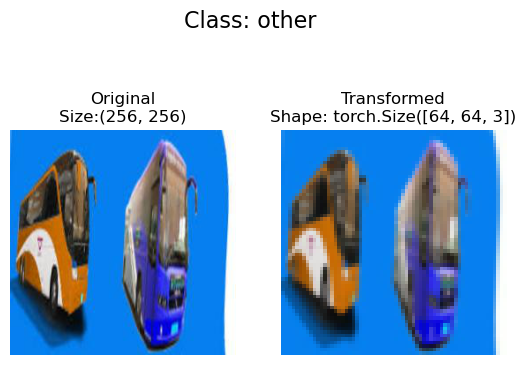

In [7]:
from helper_functions import plot_transformed_images

plot_transformed_images(image_path_list,transform=data_transformer)

In [8]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transformer,
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transformer)
print(f"Train Data:\n{train_data}\nTest Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 11170
    Root location: data\militaryvsother\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 2792
    Root location: data\militaryvsother\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [9]:
#train data size, test data size and percentage of test to train
len(train_data),len(test_data),(len(test_data)/(len(train_data)+len(test_data))*100)

(11170, 2792, 19.997135080933965)

In [10]:
classes=train_data.classes
class_dict=train_data.class_to_idx
classes,class_dict

(['millitary', 'other'], {'millitary': 0, 'other': 1})

In [11]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE=128
NUM_WORKERS=os.cpu_count()

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=True)


test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=NUM_WORKERS,
                           shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1e39250ab80>,
 <torch.utils.data.dataloader.DataLoader at 0x1e39250abb0>)

In [12]:
from helper_functions import set_seeds
set_seeds()

class MilitaryNormalClassModel(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), #hyperparameters of Conv2d
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#kernel size can also be a tuple such as (2,2)

        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier_layer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)#out features -> class_names
        )

    def forward(self,x:torch.tensor):
        x=self.conv_block_1(x)
        #print(f"Output shape after conv block 1: {x.shape}")
        x=self.conv_block_2(x)
        #print(f"Output shape after conv block 2: {x.shape}")
        x=self.classifier_layer(x)
        #print(f"Output shape after classifier layer: {x.shape}")
        return x

In [13]:
model_0=MilitaryNormalClassModel(input_shape=3,
                                 hidden_units=30,
                                 output_shape=len(classes)).to(device)

In [14]:
#Setup loss function eval metrics and optimizer
from helper_functions import accuracy_fn

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from helper_functions import print_train_time, test_step, train_step 

from timeit import default_timer as timer


train_time_start_model_0=timer()

epochs=30

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n-------------")
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_0,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_0=timer()
total_train_time_model_2=print_train_time(start=train_time_start_model_0,
                                          end=train_time_end_model_0,
                                          device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
-------------
Train loss: 0.68842 | Train acc: 54.08%


  3%|▎         | 1/30 [00:57<27:44, 57.41s/it]


Test loss: 0.6871, Test acc 54.2556
Epoch: 2
-------------
Train loss: 0.68649 | Train acc: 54.08%


  7%|▋         | 2/30 [01:45<24:17, 52.05s/it]


Test loss: 0.6853, Test acc 54.1084
Epoch: 3
-------------
Train loss: 0.68271 | Train acc: 54.01%


 10%|█         | 3/30 [02:35<23:01, 51.18s/it]


Test loss: 0.6797, Test acc 56.1884
Epoch: 4
-------------
Train loss: 0.67206 | Train acc: 56.87%


 13%|█▎        | 4/30 [03:24<21:39, 49.98s/it]


Test loss: 0.6718, Test acc 54.6233
Epoch: 5
-------------
Train loss: 0.65572 | Train acc: 61.34%


 17%|█▋        | 5/30 [04:11<20:30, 49.24s/it]


Test loss: 0.6479, Test acc 62.6452
Epoch: 6
-------------
Train loss: 0.64534 | Train acc: 63.46%


 20%|██        | 6/30 [04:59<19:30, 48.78s/it]


Test loss: 0.6550, Test acc 61.5151
Epoch: 7
-------------
Train loss: 0.63503 | Train acc: 64.62%


 23%|██▎       | 7/30 [05:47<18:32, 48.39s/it]


Test loss: 0.6272, Test acc 65.7456
Epoch: 8
-------------
Train loss: 0.62355 | Train acc: 65.84%


 27%|██▋       | 8/30 [06:35<17:39, 48.16s/it]


Test loss: 0.6114, Test acc 67.5170
Epoch: 9
-------------
Train loss: 0.60308 | Train acc: 68.36%


 30%|███       | 9/30 [07:22<16:48, 48.03s/it]


Test loss: 0.6035, Test acc 68.4398
Epoch: 10
-------------
Train loss: 0.58352 | Train acc: 70.22%


 33%|███▎      | 10/30 [08:10<15:59, 47.96s/it]


Test loss: 0.7073, Test acc 54.0911
Epoch: 11
-------------
Train loss: 0.53919 | Train acc: 73.14%


 37%|███▋      | 11/30 [08:58<15:08, 47.82s/it]


Test loss: 0.5135, Test acc 75.9781
Epoch: 12
-------------
Train loss: 0.51005 | Train acc: 74.91%


 40%|████      | 12/30 [09:45<14:19, 47.74s/it]


Test loss: 0.4942, Test acc 76.6105
Epoch: 13
-------------
Train loss: 0.49605 | Train acc: 76.07%


 43%|████▎     | 13/30 [10:33<13:30, 47.67s/it]


Test loss: 0.5157, Test acc 73.6647
Epoch: 14
-------------
Train loss: 0.49197 | Train acc: 76.26%


 47%|████▋     | 14/30 [11:20<12:42, 47.66s/it]


Test loss: 0.4858, Test acc 77.2518
Epoch: 15
-------------
Train loss: 0.48369 | Train acc: 76.77%


 50%|█████     | 15/30 [12:08<11:54, 47.63s/it]


Test loss: 0.4961, Test acc 76.9965
Epoch: 16
-------------
Train loss: 0.48519 | Train acc: 76.35%


 53%|█████▎    | 16/30 [12:56<11:07, 47.67s/it]


Test loss: 0.5566, Test acc 70.9078
Epoch: 17
-------------
Train loss: 0.47280 | Train acc: 77.80%


 57%|█████▋    | 17/30 [13:44<10:21, 47.80s/it]


Test loss: 0.5234, Test acc 74.7039
Epoch: 18
-------------
Train loss: 0.46984 | Train acc: 78.06%


 60%|██████    | 18/30 [14:32<09:34, 47.86s/it]


Test loss: 0.4454, Test acc 79.7643
Epoch: 19
-------------
Train loss: 0.46839 | Train acc: 77.73%


 63%|██████▎   | 19/30 [15:20<08:46, 47.88s/it]


Test loss: 0.4562, Test acc 78.4033
Epoch: 20
-------------
Train loss: 0.46666 | Train acc: 78.52%


 67%|██████▋   | 20/30 [16:08<07:59, 48.00s/it]


Test loss: 0.4931, Test acc 76.0465
Epoch: 21
-------------
Train loss: 0.45554 | Train acc: 78.78%


 70%|███████   | 21/30 [16:56<07:11, 47.93s/it]


Test loss: 0.4332, Test acc 80.7957
Epoch: 22
-------------
Train loss: 0.45549 | Train acc: 78.59%


 73%|███████▎  | 22/30 [17:43<06:22, 47.85s/it]


Test loss: 0.4886, Test acc 75.5624
Epoch: 23
-------------
Train loss: 0.45295 | Train acc: 79.34%


 77%|███████▋  | 23/30 [18:31<05:34, 47.78s/it]


Test loss: 0.4251, Test acc 81.2448
Epoch: 24
-------------
Train loss: 0.44185 | Train acc: 79.73%


 80%|████████  | 24/30 [19:19<04:46, 47.83s/it]


Test loss: 0.4468, Test acc 80.5053
Epoch: 25
-------------
Train loss: 0.44375 | Train acc: 79.72%


 83%|████████▎ | 25/30 [20:07<03:59, 47.86s/it]


Test loss: 0.4325, Test acc 80.3434
Epoch: 26
-------------
Train loss: 0.43396 | Train acc: 80.57%


 87%|████████▋ | 26/30 [20:55<03:11, 47.87s/it]


Test loss: 0.4358, Test acc 80.3878
Epoch: 27
-------------
Train loss: 0.44466 | Train acc: 79.30%


 90%|█████████ | 27/30 [21:42<02:23, 47.75s/it]


Test loss: 0.4423, Test acc 78.6613
Epoch: 28
-------------
Train loss: 0.42794 | Train acc: 80.60%


 93%|█████████▎| 28/30 [22:30<01:35, 47.74s/it]


Test loss: 0.4271, Test acc 80.1533
Epoch: 29
-------------
Train loss: 0.42872 | Train acc: 80.21%


 97%|█████████▋| 29/30 [23:17<00:47, 47.68s/it]


Test loss: 0.4161, Test acc 81.0829
Epoch: 30
-------------
Train loss: 0.42015 | Train acc: 81.17%


100%|██████████| 30/30 [24:05<00:00, 48.19s/it]


Test loss: 0.4234, Test acc 80.4097

Train time on cuda: 1445.784 seconds
